# Project 1
## Quantitative Analysis of New York City Traffic Congestion
### How is the pause of issuing FHV licenses improving traffic congestion and earnings in Manhattan Borough









###### Start the project by importing library and packages

In [74]:
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import glob
import folium
import json
import os
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.model_selection import train_test_split # used for splitting training and testing data
from sklearn.preprocessing import StandardScaler # used for feature scaling
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import save, reset_output, output_notebook
import geopandas as gpd
from statsmodels.formula.api import *
from scipy.stats import zscore
from glmnet import ElasticNet

###### Filtered warnings

In [75]:
import warnings
warnings.filterwarnings("ignore")

###### Read the dataset and use pickle to save the run time

In [76]:
gre_19_07 = pd.read_csv("green_tripdata_2019-07.csv", header=0,low_memory=False,  encoding='latin-1')
gre_19_08 = pd.read_csv("green_tripdata_2019-08.csv", header=0,low_memory=False,  encoding='latin-1')
yel_19_07 = pd.read_csv("yellow_tripdata_2019-07.csv", header=0,low_memory=False,  encoding='latin-1')
yel_19_08 = pd.read_csv("yellow_tripdata_2019-08.csv", header=0,low_memory=False,  encoding='latin-1')

gre_18_07 = pd.read_csv("green_tripdata_2018-07.csv", header=0,low_memory=False,  encoding='latin-1')
gre_18_08 = pd.read_csv("green_tripdata_2018-08.csv", header=0,low_memory=False,  encoding='latin-1')
yel_18_07 = pd.read_csv("yellow_tripdata_2018-07.csv", header=0,low_memory=False,  encoding='latin-1')
yel_18_08 = pd.read_csv("yellow_tripdata_2018-08.csv", header=0,low_memory=False,  encoding='latin-1')


gre_19_07.to_pickle('green_tripdata_2019_07.pkl')
gre_19_08.to_pickle('green_tripdata_2019_08.pkl')
yel_19_07.to_pickle('yellow_tripdata_2019_07.pkl')
yel_19_08.to_pickle('yellow_tripdata_2019_08.pkl')

gre_18_07.to_pickle('green_tripdata_2018_07.pkl')
gre_18_08.to_pickle('green_tripdata_2018_08.pkl')
yel_18_07.to_pickle('yellow_tripdata_2018_07.pkl')
yel_18_08.to_pickle('yellow_tripdata_2018_08.pkl')

In [77]:
df_pickle_yel_18_07 = pd.read_pickle('yellow_tripdata_2018_07.pkl')
df_pickle_yel_18_08 = pd.read_pickle('yellow_tripdata_2018_08.pkl')
df_pickle_yel_19_07 = pd.read_pickle('yellow_tripdata_2019_07.pkl')
df_pickle_yel_19_08 = pd.read_pickle('yellow_tripdata_2019_08.pkl')


df_pickle_gre_18_07 = pd.read_pickle('green_tripdata_2018_07.pkl')
df_pickle_gre_18_08 = pd.read_pickle('green_tripdata_2018_08.pkl')
df_pickle_gre_19_07 = pd.read_pickle('green_tripdata_2019_07.pkl')
df_pickle_gre_19_08 = pd.read_pickle('green_tripdata_2019_08.pkl')

### Preprocessing of External datasets

In [78]:
weather = pd.read_csv("central_park_weather.csv")
weather.to_pickle("weather.pkl")
df_pickle_weather = pd.read_pickle("weather.pkl")

###### The weather and traffic speed data are preprocessed in other notebooks, and loaded here. 
###### Because the dataset is too big to upload, I use Jupyter notebook to preprocess the data first.

In [79]:
df_weather = pd.read_csv("new_df_weather") #Preprocess weather dataset.ipynb
df_speed = pd.read_csv("new_df_traffic") #Preprocessing of traffic data.ipynb

###### combine the datasets together for visualisation and other analysis

In [80]:
df_yel_19 = df_pickle_yel_19_07.append([df_pickle_yel_19_08])
df_yel_18 = df_pickle_yel_18_07.append([df_pickle_yel_18_08])

df_gre_19 = df_pickle_gre_19_07.append([df_pickle_gre_19_08])
df_gre_18 = df_pickle_gre_18_07.append([df_pickle_gre_18_08])

In [81]:
df_yel = df_yel_18.append([df_yel_19])
df_gre = df_gre_18.append([df_gre_19])

In [82]:
#Filtered all instances that have 0 passenger count
df_yel = df_yel[df_yel["passenger_count"]!=0]
df_gre = df_gre[df_gre["passenger_count"]!=0]

#Filtered all instances that have 0 trip distance
df_yel = df_yel[df_yel["trip_distance"]!=0]
df_gre = df_gre[df_gre["trip_distance"]!=0]

#Filtered all instances that have payment 1 and 2. 
#I didn't consider tips as a relevent attribute in my study, so card and cash payments are all good.
df_yel = df_yel[(df_yel["payment_type"]<=2.0)]
df_gre = df_gre[(df_gre["payment_type"]<=2.0)]

#Filtered RateCodeID by only choose the Standard rate.
df_yel = df_yel[(df_yel["RatecodeID"]==1.0)]
df_gre = df_gre[(df_gre["RatecodeID"]==1.0)]

In [83]:
#format datetime
#repeat the same precedure for green taxi
df_yel['tpep_pickup_datetime']=pd.to_datetime(df_yel['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df_yel['tpep_dropoff_datetime']=pd.to_datetime(df_yel['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

df_gre['lpep_pickup_datetime']=pd.to_datetime(df_gre['lpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df_gre['lpep_dropoff_datetime']=pd.to_datetime(df_gre['lpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')


#Splitting timestamp column into separate date and time columns
df_yel['Dates_pickup'] = pd.to_datetime(df_yel['tpep_pickup_datetime']).dt.date
df_yel['Time_pickup'] = pd.to_datetime(df_yel['tpep_pickup_datetime']).dt.time

df_yel['Dates_dropoff'] = pd.to_datetime(df_yel['tpep_dropoff_datetime']).dt.date
df_yel['Time_dropoff'] = pd.to_datetime(df_yel['tpep_dropoff_datetime']).dt.time

#Splitting timestamp column into separate date and time columns
df_gre['Dates_pickup'] = pd.to_datetime(df_gre['lpep_pickup_datetime']).dt.date
df_gre['Time_pickup'] = pd.to_datetime(df_gre['lpep_pickup_datetime']).dt.time

df_gre['Dates_dropoff'] = pd.to_datetime(df_gre['lpep_dropoff_datetime']).dt.date
df_gre['Time_dropoff'] = pd.to_datetime(df_gre['lpep_dropoff_datetime']).dt.time

##### Filtered all data that has dates not within the time period of July and August 2018, 2019.

In [84]:
#format datetime
df_yel['Dates_pickup']=pd.to_datetime(df_yel['Dates_pickup'], format="%Y-%m-%d")
df_gre['Dates_pickup']=pd.to_datetime(df_gre['Dates_pickup'], format="%Y-%m-%d")

In [85]:
df_yel_18 = df_yel[(df_yel['Dates_pickup'] > "2018-7-1") & (df_yel['Dates_pickup'] < "2018-8-30")]
df_yel_19 = df_yel[(df_yel['Dates_pickup'] > "2019-7-1") & (df_yel['Dates_pickup'] < "2019-8-30")]
df_gre_18 = df_gre[(df_gre['Dates_pickup'] > "2018-7-1") & (df_gre['Dates_pickup'] < "2018-8-30")]
df_gre_19 = df_gre[(df_gre['Dates_pickup'] > "2019-7-1") & (df_gre['Dates_pickup'] < "2019-8-30")]

In [86]:
#greater than the start date and smaller than the end date
mask_time_yel_18 = (df_yel['Dates_pickup'] >= "2018-7-1") & (df_yel['Dates_pickup'] <= "2018-8-30")
mask_time_yel_19 = (df_yel['Dates_pickup'] >= "2019-7-1") & (df_yel['Dates_pickup'] <= "2019-8-30")

mask_time_gre_18 = (df_gre['Dates_pickup'] >= "2018-7-1") & (df_gre['Dates_pickup'] <= "2018-8-30")
mask_time_gre_19 = (df_gre['Dates_pickup'] >= "2019-7-1") & (df_gre['Dates_pickup'] <= "2019-8-30")

In [87]:
df_yel_18 = df_yel.loc[mask_time_yel_18]
df_yel_19 = df_yel.loc[mask_time_yel_19]
df_gre_18 = df_gre.loc[mask_time_gre_18]
df_gre_19 = df_gre.loc[mask_time_gre_19]

In [88]:
#combine the dataset together
df_yel = df_yel_18.append([df_yel_19])

df_gre = df_gre_18.append([df_gre_19])

In [89]:
df_gre.dtypes

VendorID                        float64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
Dates_pickup             datetime64[ns]
Time_pickup                      object
Dates_dropoff                    object
Time_dropoff                     object
dtype: object

In [90]:
df_yel.dtypes

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Dates_pickup             datetime64[ns]
Time_pickup                      object
Dates_dropoff                    object
Time_dropoff                     object
dtype: object

In [91]:
df_yel.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Dates_pickup,Time_pickup,Dates_dropoff,Time_dropoff
0,1.0000,2018-07-01 00:28:09,2018-07-01 00:28:51,1.0000,5.3000,1.0000,N,145,145,2.0000,...,0.5000,0.0000,0.0000,0.3000,3.8000,NaN,2018-07-01,00:28:09,2018-07-01,00:28:51
1,1.0000,2018-07-01 00:29:27,2018-07-01 00:30:17,1.0000,5.3000,1.0000,N,145,145,2.0000,...,0.5000,0.0000,0.0000,0.3000,3.8000,NaN,2018-07-01,00:29:27,2018-07-01,00:30:17
2,1.0000,2018-07-01 00:04:19,2018-07-01 00:08:29,2.0000,0.7000,1.0000,N,211,144,1.0000,...,0.5000,1.2500,0.0000,0.3000,7.5500,NaN,2018-07-01,00:04:19,2018-07-01,00:08:29
3,1.0000,2018-07-01 00:14:26,2018-07-01 00:36:35,1.0000,4.8000,1.0000,N,144,142,1.0000,...,0.5000,1.0000,0.0000,0.3000,20.3000,NaN,2018-07-01,00:14:26,2018-07-01,00:36:35
4,1.0000,2018-07-01 00:41:56,2018-07-01 00:50:54,1.0000,1.8000,1.0000,N,142,141,2.0000,...,0.5000,0.0000,0.0000,0.3000,9.8000,NaN,2018-07-01,00:41:56,2018-07-01,00:50:54


In [92]:
df_gre.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,Dates_pickup,Time_pickup,Dates_dropoff,Time_dropoff
0,2.0000,2018-07-01 00:41:27,2018-07-01 01:06:15,N,1.0000,33,50,5.0000,6.3700,22.5000,...,NaN,0.3000,28.5600,1.0000,1.0000,NaN,2018-07-01,00:41:27,2018-07-01,01:06:15
1,1.0000,2018-07-01 00:43:30,2018-07-01 00:59:51,N,1.0000,25,224,1.0000,5.3000,18.0000,...,NaN,0.3000,22.5600,1.0000,1.0000,NaN,2018-07-01,00:43:30,2018-07-01,00:59:51
2,2.0000,2018-07-01 01:00:40,2018-07-01 01:13:36,N,1.0000,65,225,1.0000,2.9800,12.0000,...,NaN,0.3000,13.3000,2.0000,1.0000,NaN,2018-07-01,01:00:40,2018-07-01,01:13:36
3,1.0000,2018-07-01 00:23:43,2018-07-01 00:32:49,N,1.0000,7,223,1.0000,1.4000,8.0000,...,NaN,0.3000,9.3000,2.0000,1.0000,NaN,2018-07-01,00:23:43,2018-07-01,00:32:49
4,2.0000,2018-07-01 00:20:41,2018-07-01 00:24:05,N,1.0000,33,25,2.0000,1.0300,5.0000,...,NaN,0.3000,8.1900,1.0000,1.0000,NaN,2018-07-01,00:20:41,2018-07-01,00:24:05


In [93]:
#Filtered any instances that have the same pickup and dropoff time
df_yel = df_yel[df_yel["tpep_pickup_datetime"]!=df_yel["tpep_dropoff_datetime"]]
df_gre = df_gre[df_gre["lpep_pickup_datetime"]!=df_gre["lpep_dropoff_datetime"]]

In [139]:
#Fill all NaN value with 0
df_yel = df_yel.fillna(0)
df_gre = df_gre.fillna(0)

In [140]:
#Select only wanted study attributes
df_yel = df_yel[["PULocationID", "DOLocationID", "passenger_count", "trip_distance", "fare_amount", "extra",
                 "mta_tax", "tolls_amount", "improvement_surcharge", "total_amount", "payment_type",
                 "congestion_surcharge", "Dates_pickup", "Time_pickup", "Dates_dropoff", "Time_dropoff"
                ]]

df_gre = df_gre[["PULocationID", "DOLocationID", "passenger_count", "trip_distance", "fare_amount", "extra",
                 "mta_tax", "tolls_amount", "improvement_surcharge", "total_amount", "payment_type",
                "trip_type", "congestion_surcharge", "Dates_pickup", "Time_pickup", "Dates_dropoff", "Time_dropoff"]]

## Analysis and Geospatial Visualisation

### Preliminary analysis

In [141]:
TILE = get_provider("STAMEN_TERRAIN_RETINA")

reset_output()
output_notebook()

Loading BokehJS ...

In [142]:
# sf stands for shape file
sf = gpd.read_file("MAST30034_Python/data/taxi_zones/taxi_zones.shp")
zone = pd.read_csv("taxi+_zone_lookup.csv")

# Convert the geometry shape to to latitude and longitude
# Please attribute this if you are using it
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

create a `gdf` with our current dataframe and shapefile data.

From `df`, we join using `PULocationID` to match from `sf`'s `LocationID`

In [143]:
sf_Man = sf[sf["borough"] == "Manhattan"]

In [144]:
LocationID_Man = sf_Man["LocationID"].tolist()

In [145]:
gdf_yel = gpd.GeoDataFrame(pd.merge(df_yel, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
gdf_gre = gpd.GeoDataFrame(pd.merge(df_gre, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)

In [146]:
geoJSON_yel = gdf_yel[['LocationID','geometry']].drop_duplicates('LocationID').to_json()
geoJSON_gre = gdf_gre[['LocationID','geometry']].drop_duplicates('LocationID').to_json()

In [ ]:
m_yel = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on how to plot aggregated data.
m_yel.add_child(folium.Choropleth(
    geo_data=geoJSON_yel,
    name='choropleth',
))

m_yel.save('foliumChoroplethMap_yel.html')
m_yel

In [ ]:
m_gre = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on how to plot aggregated data.
m_gre.add_child(folium.Choropleth(
    geo_data=geoJSON_gre,
    name='choropleth',
))

m_gre.save('foliumChoroplethMap_gre.html')
m_gre

In [ ]:
m_trip_distance = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON_yel, # geoJSON 
    name='choropleth', # name of plot
    data=gdf_yel, # data source
    columns=['LocationID','fare_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Trips' # legend title
).add_to(m_trip_distance)

m_trip_distance.save('foliumChoroplethMapTrips_yel.html')
m_trip_distance

In [147]:
#Here I want the location only in Manhattan
df_yel = df_yel[df_yel["PULocationID"].isin(LocationID_Man) & df_yel["DOLocationID"].isin(LocationID_Man)]
df_gre = df_gre[df_gre["PULocationID"].isin(LocationID_Man) & df_gre["DOLocationID"].isin(LocationID_Man)]

In [148]:
gdf_yel = gpd.GeoDataFrame(pd.merge(df_yel, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
gdf_gre = gpd.GeoDataFrame(pd.merge(df_gre, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
geoJSON_yel = gdf_yel[['LocationID','geometry']].drop_duplicates('LocationID').to_json()
geoJSON_gre = gdf_gre[['LocationID','geometry']].drop_duplicates('LocationID').to_json()

In [ ]:
m_trip_distance = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON_yel, # geoJSON 
    name='choropleth', # name of plot
    data=gdf_yel, # data source
    columns=['LocationID','fare_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Trips' # legend title
).add_to(m_trip_distance)

m_trip_distance.save('MAST30034_Python/plots/foliumChoroplethMapTrips_yel_Man.html')
m_trip_distance

In [ ]:
m_trip_distance = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON_gre, # geoJSON 
    name='choropleth', # name of plot
    data=gdf_gre, # data source
    columns=['LocationID','fare_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Trips' # legend title
).add_to(m_trip_distance)

m_trip_distance.save('MAST30034_Python/plots/foliumChoroplethMapTrips_gre_Man.html')
m_trip_distance

In [149]:
#group by the dataset by dates
new_df_yel = df_yel.groupby([df_yel['Dates_pickup']])["passenger_count", "trip_distance", "fare_amount", 
                                                      "extra","mta_tax", "tolls_amount", "improvement_surcharge", 
                                                      "total_amount", "congestion_surcharge"].mean()
new_df_gre = df_gre.groupby([df_gre['Dates_pickup']])["passenger_count", "trip_distance", "fare_amount", 
                                                      "extra","mta_tax", "tolls_amount", "improvement_surcharge", 
                                                      "total_amount", "congestion_surcharge"].mean()
                                          

In [150]:
df_weather.tail(5)

,index,Unnamed: 0,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
117,117,3889,2019-08-26,6.2600,0.0000,0.0000,0.0000,74,61
118,118,3890,2019-08-27,3.1300,0.0000,0.0000,0.0000,75,62
119,119,3891,2019-08-28,3.8000,0.0800,0.0000,0.0000,74,67
120,120,3892,2019-08-29,4.0300,0.0000,0.0000,0.0000,81,65
121,121,3893,2019-08-30,4.0300,0.0000,0.0000,0.0000,86,67


In [151]:
df_speed.tail(5)

,index,Dates,SPEED,TRAVEL_TIME,DATE
116,116,2019-08-26,31.1896,267.9793,2019-08-25
117,117,2019-08-27,30.3354,274.2666,2019-08-26
118,118,2019-08-28,28.6105,288.8036,2019-08-27
119,119,2019-08-29,28.6330,293.1387,2019-08-28
120,120,2019-08-30,29.4260,280.6258,2019-08-29


In [152]:
new_df_yel.tail(5)

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
Dates_pickup,,,,,,,,,
2019-08-26,1.5723,1.8939,9.4329,1.2198,0.4997,0.0018,0.2998,14.7156,2.4313
2019-08-27,1.5642,1.8846,9.5922,1.2256,0.4996,0.0017,0.2998,14.9619,2.4383
2019-08-28,1.5714,1.8381,9.6602,1.2243,0.4996,0.0019,0.2998,15.0648,2.4395
2019-08-29,1.5691,1.8833,9.7158,1.2279,0.4997,0.0020,0.2998,15.0857,2.4336
2019-08-30,1.6216,1.8852,9.4777,1.2107,0.4997,0.0058,0.2998,14.7196,2.4197


### Now is the time to create a complete data frame with all attributed wither created or derived.

In [153]:
#
df_weather = df_weather.reset_index()
df_speed = df_speed.reset_index()
new_df_yel = new_df_yel.reset_index()
new_df_gre = new_df_gre.reset_index()

In [154]:
df_speed["DATE"] = df_weather["DATE"]
new_df_yel["DATE"] = df_weather["DATE"]
new_df_gre["DATE"] = df_weather["DATE"]

In [155]:
df1 = new_df_yel.join(df_speed, lsuffix="_left")
df_all_yel = df1.join(df_weather, lsuffix="_left")

df2 = new_df_gre.join(df_speed, lsuffix="_left")
df_all_gre = df2.join(df_weather, lsuffix="_left")

In [156]:
df_all_yel = df_all_yel.drop(['DATE_left', 'index_left', "Unnamed: 0", "DATE", "index", "Dates"], axis=1)

In [157]:
df_all_gre = df_all_gre.drop(['DATE_left', 'index_left', "Unnamed: 0", "DATE", "index", "Dates"], axis=1)

In [158]:
df_all_yel.dtypes

Dates_pickup             datetime64[ns]
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
level_0_left                    float64
SPEED                           float64
TRAVEL_TIME                     float64
level_0                           int64
AWND                            float64
PRCP                            float64
SNOW                            float64
SNWD                            float64
TMAX                              int64
TMIN                              int64
dtype: object

In [159]:
df_all_yel.iloc[:61]

,Dates_pickup,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,level_0_left,SPEED,TRAVEL_TIME,level_0,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
0,2018-07-01,1.6707,1.9530,9.0829,0.1713,0.4999,0.0017,0.3000,11.2488,0.0000,0.0000,29.4812,257.4294,0,2.9100,0.0000,0.0000,0.0000,96,79
1,2018-07-02,1.6079,1.8063,9.3504,0.3693,0.4999,0.0012,0.3000,11.8154,0.0000,1.0000,27.6485,292.8156,1,2.0100,0.0000,0.0000,0.0000,95,79
2,2018-07-03,1.6171,1.7746,9.4250,0.3586,0.4999,0.0012,0.3000,11.9067,0.0000,2.0000,26.8341,301.0348,2,1.1200,0.0100,0.0000,0.0000,92,77
3,2018-07-04,1.7033,1.9508,8.9499,0.1962,0.5000,0.0023,0.3000,11.1238,0.0000,3.0000,29.4102,279.3266,3,1.1200,0.0000,0.0000,0.0000,86,77
4,2018-07-05,1.6341,1.8459,9.3151,0.3770,0.4999,0.0016,0.3000,11.7287,0.0000,4.0000,27.9458,288.5651,4,2.9100,0.0000,0.0000,0.0000,90,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2018-08-26,1.6729,2.0132,9.3064,0.1799,0.5000,0.0020,0.3000,11.5090,0.0000,56.0000,23.2406,331.0623,56,3.3600,0.0000,0.0000,0.0000,83,69
57,2018-08-27,1.5956,1.8386,9.2844,0.3791,0.5000,0.0014,0.3000,11.7828,0.0000,57.0000,22.8071,346.8411,57,2.4600,0.0000,0.0000,0.0000,88,74
58,2018-08-28,1.6013,1.8037,9.6249,0.3782,0.5000,0.0014,0.3000,12.2121,0.0000,58.0000,25.4517,318.0178,58,3.8000,0.0000,0.0000,0.0000,94,79
59,2018-08-29,1.5892,1.7995,9.6086,0.3750,0.5000,0.0017,0.3000,12.2068,0.0000,59.0000,23.9640,338.4490,59,4.9200,0.0000,0.0000,0.0000,92,81


### Analysing relationships between attributes

<AxesSubplot:xlabel='fare_amount', ylabel='SPEED'>

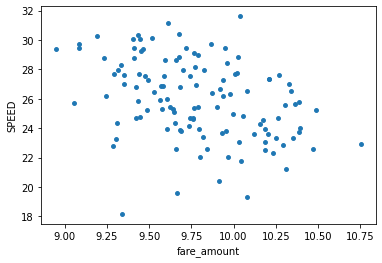

In [160]:
df_all_yel.plot.scatter(x = 'fare_amount', y = 'SPEED', s = 15)

<AxesSubplot:xlabel='fare_amount', ylabel='SPEED'>

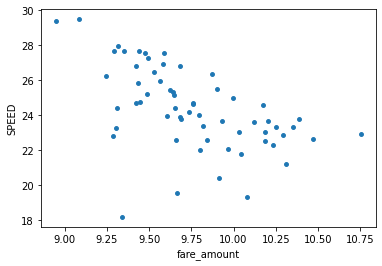

In [161]:
df_all_yel.iloc[:61].plot.scatter(x = 'fare_amount', y = 'SPEED', s = 15)

<AxesSubplot:xlabel='fare_amount', ylabel='SPEED'>

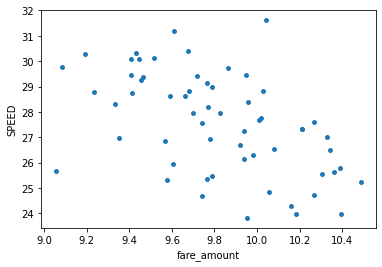

In [162]:
df_all_yel.iloc[61:].plot.scatter(x = 'fare_amount', y = 'SPEED', s = 15)

<AxesSubplot:xlabel='fare_amount', ylabel='SPEED'>

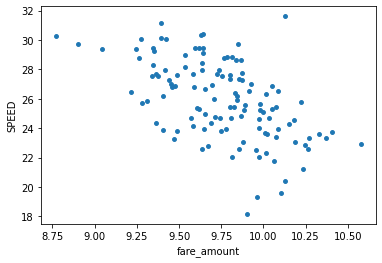

In [163]:
df_all_gre.plot.scatter(x = 'fare_amount', y = 'SPEED', s = 15)

<AxesSubplot:xlabel='fare_amount', ylabel='SPEED'>

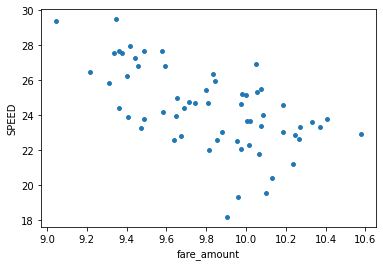

In [164]:
df_all_gre.iloc[:61].plot.scatter(x = 'fare_amount', y = 'SPEED', s = 15)

<AxesSubplot:xlabel='fare_amount', ylabel='SPEED'>

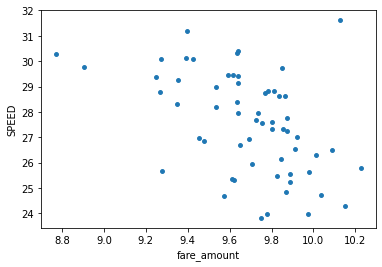

In [165]:
df_all_gre.iloc[61:].plot.scatter(x = 'fare_amount', y = 'SPEED', s = 15)

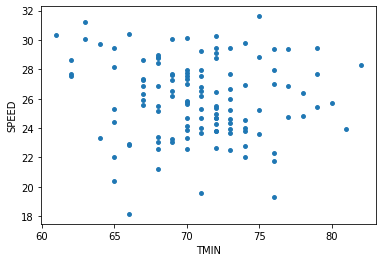

In [166]:
df_all_yel.plot.scatter(x = 'TMIN', y = 'SPEED', s = 15);

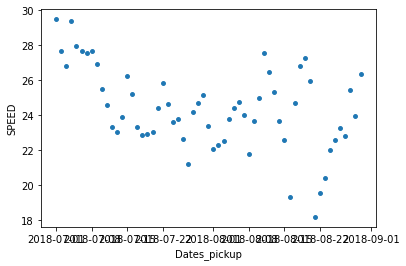

In [167]:

df_all_yel.iloc[:61].plot.scatter(x = 'Dates_pickup', y = 'SPEED', s = 15);

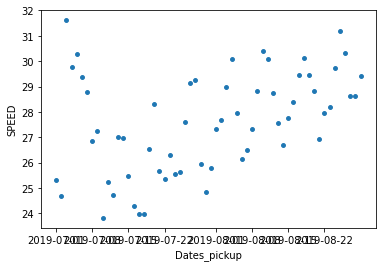

In [168]:

df_all_yel.iloc[61:].plot.scatter(x = 'Dates_pickup', y = 'SPEED', s = 15);

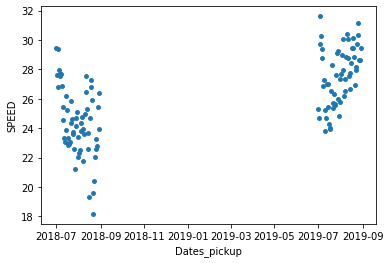

In [169]:

df_all_gre.plot.scatter(x = 'Dates_pickup', y = 'SPEED', s = 15);

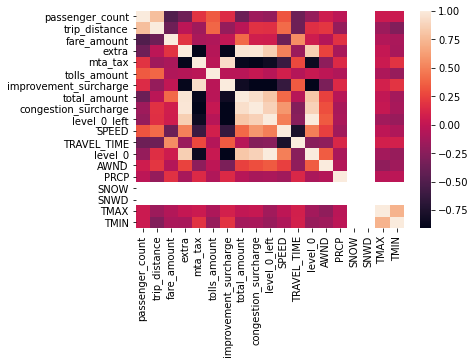

In [170]:
sns.heatmap(df_all_yel.corr())

plt.show()

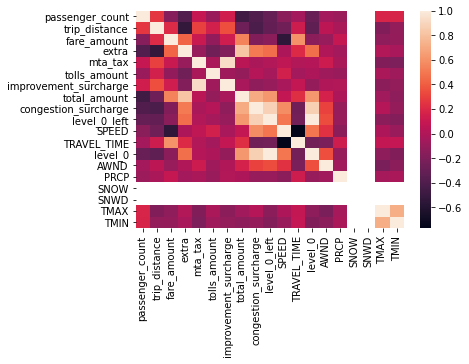

In [171]:
sns.heatmap(df_all_gre.corr())

plt.show()

In [172]:
#Delete the snow related attributes. They are useless.
df_all_yel = df_all_yel.drop(["SNOW", "SNWD"], axis=1)
df_all_gre = df_all_gre.drop(["SNOW", "SNWD"], axis=1)

In [173]:
df_all_yel = df_all_yel.drop(df_all_yel.index[121])
df_all_gre = df_all_gre.drop(df_all_gre.index[121])

In [174]:
df_all_yel

,Dates_pickup,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,level_0_left,SPEED,TRAVEL_TIME,level_0,AWND,PRCP,TMAX,TMIN
0,2018-07-01,1.6707,1.9530,9.0829,0.1713,0.4999,0.0017,0.3000,11.2488,0.0000,0.0000,29.4812,257.4294,0,2.9100,0.0000,96,79
1,2018-07-02,1.6079,1.8063,9.3504,0.3693,0.4999,0.0012,0.3000,11.8154,0.0000,1.0000,27.6485,292.8156,1,2.0100,0.0000,95,79
2,2018-07-03,1.6171,1.7746,9.4250,0.3586,0.4999,0.0012,0.3000,11.9067,0.0000,2.0000,26.8341,301.0348,2,1.1200,0.0100,92,77
3,2018-07-04,1.7033,1.9508,8.9499,0.1962,0.5000,0.0023,0.3000,11.1238,0.0000,3.0000,29.4102,279.3266,3,1.1200,0.0000,86,77
4,2018-07-05,1.6341,1.8459,9.3151,0.3770,0.4999,0.0016,0.3000,11.7287,0.0000,4.0000,27.9458,288.5651,4,2.9100,0.0000,90,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2019-08-25,1.6601,2.0679,9.6105,0.9831,0.4997,0.0020,0.2998,14.6083,2.4200,116.0000,31.1896,267.9793,116,8.9500,0.0000,77,63
117,2019-08-26,1.5723,1.8939,9.4329,1.2198,0.4997,0.0018,0.2998,14.7156,2.4313,117.0000,30.3354,274.2666,117,6.2600,0.0000,74,61
118,2019-08-27,1.5642,1.8846,9.5922,1.2256,0.4996,0.0017,0.2998,14.9619,2.4383,118.0000,28.6105,288.8036,118,3.1300,0.0000,75,62
119,2019-08-28,1.5714,1.8381,9.6602,1.2243,0.4996,0.0019,0.2998,15.0648,2.4395,119.0000,28.6330,293.1387,119,3.8000,0.0800,74,67


### Statistical modeling

In [175]:
fit_yel = ols(formula="SPEED ~ passenger_count + fare_amount + trip_distance + tolls_amount + extra + mta_tax + trip_distance + improvement_surcharge + total_amount + congestion_surcharge + AWND + PRCP + TMAX + TMIN",data=df_all_yel
    ).fit()
fit_gre = ols(formula="SPEED ~ passenger_count + fare_amount + trip_distance + tolls_amount + extra + mta_tax + trip_distance + improvement_surcharge + total_amount + congestion_surcharge + AWND + PRCP + TMAX + TMIN",data=df_all_gre
    ).fit()

In [176]:
print(fit_yel.summary())

                            OLS Regression Results                            
Dep. Variable:                  SPEED   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     19.33
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           1.91e-22
Time:                        17:56:23   Log-Likelihood:                -218.32
No. Observations:                 121   AIC:                             464.6
Df Residuals:                     107   BIC:                             503.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7078.64

In [177]:
print(fit_gre.summary())

                            OLS Regression Results                            
Dep. Variable:                  SPEED   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     13.16
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           7.26e-17
Time:                        17:56:23   Log-Likelihood:                -233.64
No. Observations:                 121   AIC:                             495.3
Df Residuals:                     107   BIC:                             534.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -371.30

### LASSO ($\ell_1$)

- LASSO may cause coefficients to be set to 0 by constraining the model.
- This is because we put a constraint where the sum of the absolute values of the coefficients must be less than some fixed value. 
- As such, some coefficients may end up having 0 which is the same as *dropping* the attribute from the model.
- In this sense, it's quite similar to feature selection as you end up with a model that is much more simpler. 
- However, LASSO does not do well when the feature space is small as you may end up with an over-simplified model, as well as cases where all the features are significant or when coefficients are extremely large. 

Solution:
- Requires an iterative method to solve $(\mathbf{y}-X\beta)^T(\mathbf{y}-X\beta) + \lambda I \beta$

In [178]:
yCOLS = ['SPEED']
xCOLS = ['passenger_count', 'fare_amount', 'trip_distance', 'tolls_amount', 'extra', 'mta_tax', 'trip_distance','improvement_surcharge', 'total_amount', 'congestion_surcharge', 'AWND', 'PRCP', 'TMAX', 'TMIN']
df_standard_yel = df_all_yel[xCOLS].astype(float).apply(zscore)
df_standard_gre = df_all_gre[xCOLS].astype(float).apply(zscore)

In [179]:
# format output to 4 decimal places
pd.options.display.float_format = '{:,.4f}'.format
df_standard_yel.describe().loc[['mean','std']]
df_standard_gre.describe().loc[['mean','std']]

,passenger_count,fare_amount,trip_distance,tolls_amount,extra,mta_tax,trip_distance,improvement_surcharge,total_amount,congestion_surcharge,AWND,PRCP,TMAX,TMIN
mean,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000
std,1.0042,1.0042,1.0042,1.0042,1.0042,1.0042,1.0042,1.0042,1.0042,1.0042,1.0042,1.0042,1.0042,1.0042


In [180]:
lasso_fit_yel = ElasticNet()
lasso_fit_yel.fit(df_standard_yel.values, df_all_yel[yCOLS].values)

lasso_fit_gre = ElasticNet()
lasso_fit_gre.fit(df_standard_gre.values, df_all_gre[yCOLS].values)

ElasticNet()

In [181]:
# this can be accessed using the .lambda_best_ method after fitting!
print(f'Best lambda value for LASSO: {lasso_fit_yel.lambda_best_[0]}')

Best lambda value for LASSO: 0.5140364744640212


In [182]:
pd.DataFrame(index = ['Intercept'] + xCOLS, 
             data= [lasso_fit_yel.intercept_] + list(lasso_fit_yel.coef_), 
             columns = ['Coefficient'])

,Coefficient
Intercept,25.9594
passenger_count,0.3474
fare_amount,-0.3947
trip_distance,0.0000
tolls_amount,0.0000
extra,0.0000
mta_tax,-0.5975
trip_distance,0.0000
improvement_surcharge,-0.7107
total_amount,0.0000


In [183]:
pd.DataFrame(index = ['Intercept'] + xCOLS, 
             data= [lasso_fit_gre.intercept_] + list(lasso_fit_gre.coef_), 
             columns = ['Coefficient'])

,Coefficient
Intercept,25.9594
passenger_count,0.0000
fare_amount,-0.7978
trip_distance,0.0000
tolls_amount,0.0000
extra,0.0000
mta_tax,0.0000
trip_distance,0.0000
improvement_surcharge,0.0000
total_amount,0.0000
